In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Importing the Required Libraries for processing

In [0]:
import requests 
import json
import cv2
import warnings 
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import argparse
warnings.filterwarnings('ignore')
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from imutils import paths

In [0]:
# Importing the .csv file containing the information on the train dataset
train = pd.read_csv('drive/My Drive/mask detection challenge/train_labels.csv')

In [0]:
train.head()

,image,target
0,tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg,0
1,rxgismgsvmaayzjarbfjaljhqmpbrt.jpg,1
2,uuzshfrhkgrkolhwdvliqauzulurnz.jpg,0
3,mjspxsagzusaznvnyxgamtrlqkqklp.jpg,0
4,rlbmuajgezfiddjzlyeoupxpqubkpt.jpg,1


In [0]:
IMAGES_DIR = 'drive/My Drive/mask detection challenge/images'

In [0]:
images_list = os.listdir(IMAGES_DIR)

In [0]:
train_images_list = train['image'].tolist()

In [0]:
test_images_list = [image for image in images_list if image not in train_images_list]

In [0]:
print(len(train_images_list), len(test_images_list))

1308 519


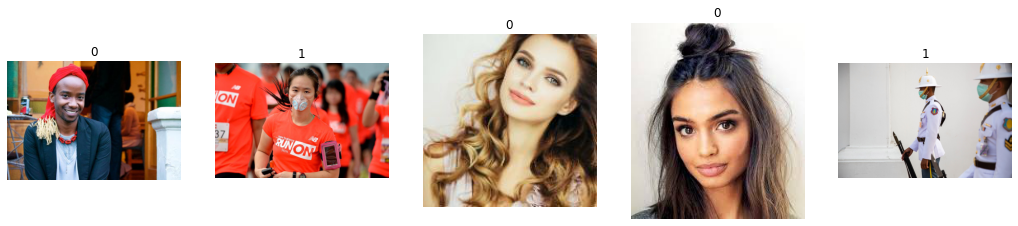

In [0]:
fig,axes = plt.subplots(1,5, figsize=(18,18))
for i in range(5):
    ax = axes[i]
    img = mpimg.imread(os.path.join(IMAGES_DIR, train_images_list[i]))
    ax.imshow(img)
    ax.set_title(train['target'][i] )
    ax.axis('off')
plt.show()

In [0]:
train_imagepaths = [os.path.join(IMAGES_DIR, imagepath) for imagepath in train_images_list]
test_imagepaths = [os.path.join(IMAGES_DIR, imagepath) for imagepath in test_images_list]

### Preprocessing Images

In [0]:
IMG_HEIGHT = 256
IMG_WIDTH = 256

def preprocess_images(path_list):

    output = []
    for imagePath in path_list:
      #Load the Image from the image path
      loaded_image = load_img(imagePath, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode ='rgb')

      #Convert the loaded image to an Array
      image_array = img_to_array(loaded_image)

      #Append the results to the train_data and labels list 
      output.append(image_array)

    return output


In [0]:
# Apply the preprocess function to the train and test images

train_images_preprocessed = preprocess_images(train_imagepaths)

In [0]:
test_images_preprocessed = preprocess_images(test_imagepaths)

In [0]:
train_images_preprocessed = np.asarray(train_images_preprocessed)
test_images_preprocessed = np.asarray(test_images_preprocessed)

In [0]:
train_images_preprocessed.shape

(1308, 256, 256, 3)

In [0]:
train_data_scaled = train_images_preprocessed/255.0
test_data_scaled = test_images_preprocessed/255.0

In [0]:
print("train data shape is :- {}, test data shape is :- {}".format(train_data_scaled.shape, test_data_scaled.shape))

train data shape is :- (1308, 256, 256, 3), test data shape is :- (519, 256, 256, 3)


In [0]:
target = np.array(train['target'])

In [0]:
lb = LabelBinarizer()
target = lb.fit_transform(target)

In [0]:
target.shape

(1308, 1)

### Modelling using a pre-trained model

In [0]:
# Splitting data into train and validation sets 

x_train, x_val, y_train, y_val = train_test_split(train_data_scaled, target, test_size=0.2, random_state=42)
print(x_train.shape, x_val.shape)

(1046, 256, 256, 3) (262, 256, 256, 3)


In [0]:
!pip install efficientnet

In [0]:
# Importing the required libraries for modelling 

from keras.layers.core import Flatten, Dense,Dropout
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model 
from keras.optimizers import Adam


from sklearn.metrics import classification_report, roc_auc_score

In [0]:
x_train[0].shape

(256, 256, 3)

In [0]:
# Training Model Layers Arrangment

import efficientnet.keras as effnet

baseModel = effnet.EfficientNetB0(weights="imagenet", include_top=False, input_shape= x_train[0].shape)
headModel = baseModel.output
headModel = GlobalAveragePooling2D(name='avg_pool')(headModel)
headModel = Dropout(0.2, name='top_dropout')(headModel)
headModel = Dense(1,activation='sigmoid')(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

In [0]:
#Loss function and its parameters 

optimizer = Adam(amsgrad = True)

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 128, 128, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 128, 128, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 128, 128, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [0]:
#Compiling the Model with binary_crossentropy loss for binary classification

model.compile(loss="binary_crossentropy", optimizer = optimizer, metrics = ['accuracy'])

In [0]:
# Setting up Callbacks for the Model

callbacks = [
    EarlyStopping(patience=8, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1)
]

In [0]:
# Seting up Data Augmentation

train_datagen = ImageDataGenerator(rotation_range=20,
                                   zoom_range=0.15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   fill_mode="nearest"
                                )

In [0]:
BATCH_SIZE = 32
N_EPOCHS = 30

history = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size= BATCH_SIZE),
                              validation_data=(x_val, y_val),
                              epochs= N_EPOCHS,
                              callbacks=callbacks
                          )

Epoch 1/30
33/33 [==============================] - 397s 12s/step - loss: 0.0269 - accuracy: 0.9933 - val_loss: 0.0701 - val_accuracy: 0.9695
Epoch 2/30
33/33 [==============================] - 381s 12s/step - loss: 0.0098 - accuracy: 0.9981 - val_loss: 0.0560 - val_accuracy: 0.9809
Epoch 3/30
33/33 [==============================] - 378s 11s/step - loss: 0.0083 - accuracy: 0.9990 - val_loss: 0.0542 - val_accuracy: 0.9656
Epoch 4/30
33/33 [==============================] - 383s 12s/step - loss: 0.0067 - accuracy: 0.9971 - val_loss: 0.0578 - val_accuracy: 0.9847
Epoch 5/30
33/33 [==============================] - 384s 12s/step - loss: 0.0053 - accuracy: 0.9990 - val_loss: 0.0552 - val_accuracy: 0.9847
Epoch 6/30
33/33 [==============================] - 385s 12s/step - loss: 0.0043 - accuracy: 0.9990 - val_loss: 0.0893 - val_accuracy: 0.9733
Epoch 7/30
33/33 [==============================] - 384s 12s/step - loss: 0.0025 - accuracy: 0.9990 - val_loss: 0.0800 - val_accuracy: 0.9771
Epoch 

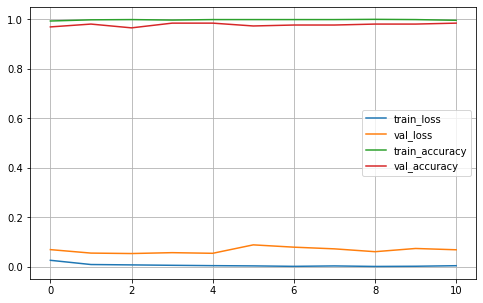

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,5))
plt.plot(np.arange(11), history.history['loss'], label = 'train_loss')
plt.plot(np.arange(11), history.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(11), history.history['accuracy'], label = 'train_accuracy')
plt.plot(np.arange(11), history.history['val_accuracy'], label = 'val_accuracy')

plt.grid(True)
plt.legend(loc = "best")
plt.show()

In [0]:
model.save_weights('drive/My Drive/mask detection challenge/model_weights_effnet.h5')

In [0]:
model_json = model.to_json()

with open('drive/My Drive/mask detection challenge/model_effnet.json', 'w') as json_file:
  json_file.write(model_json)

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 128, 128, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 128, 128, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 128, 128, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [0]:
preds = model.predict(test_data_scaled)

In [0]:
preds.shape

(519, 1)

In [0]:
preds

array([[5.60657043e-07],
       [9.99936223e-01],
       [8.88746799e-05],
       [1.30364683e-07],
       [1.00000000e+00],
       [9.93072748e-01],
       [9.99989033e-01],
       [9.99998927e-01],
       [2.33628839e-07],
       [9.99997377e-01],
       [3.39101025e-05],
       [1.31739725e-05],
       [9.99990642e-01],
       [9.99935269e-01],
       [9.98231408e-05],
       [8.08642653e-06],
       [9.99996662e-01],
       [9.99957204e-01],
       [9.99973416e-01],
       [9.99979138e-01],
       [3.58925399e-06],
       [9.99998987e-01],
       [3.33207281e-05],
       [5.30347352e-05],
       [1.19634558e-06],
       [9.99996245e-01],
       [9.99999046e-01],
       [9.99976873e-01],
       [2.14013457e-03],
       [3.27979888e-06],
       [3.71098518e-04],
       [9.99995649e-01],
       [5.29195459e-05],
       [9.99999762e-01],
       [9.99826670e-01],
       [1.57296658e-04],
       [4.20921907e-07],
       [1.64419711e-02],
       [9.08362091e-01],
       [9.99998569e-01],


In [0]:
submission_effnet = pd.DataFrame({"image":test_images_list, "target":preds.reshape(519,)})

In [0]:
submission_effnet.to_csv('drive/My Drive/mask detection challenge/submission_effnet.csv', index=False)